In [74]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
gunData = pd.read_excel('firearm_data_cleaned_new.xlsx')
gunData.head()

,year,state,rate,deaths,state_name,law_strength_score,restrictive_laws,permissive_laws,total_law_changes,rate_change,...,strength_firearm_removal_at_scene_of_domestic_violence,strength_firearms_in_college_university,strength_child_access_laws,strength_gun_trafficking,strength_open_carry,strength_required_reporting_of_lost_or_stolen_firearms,strength_safety_training_required,strength_untraceable_firearms,strength_permit_to_purchase,strength_firearms_in_k_12_educational_settings
0,2014,AK,19.2,145,Alaska,11,18,7,25,NaN,...,1,0,0,0,0,0,0,0,0,0
1,2015,AK,23.4,177,Alaska,11,18,7,25,4.2,...,1,0,0,0,0,0,0,0,0,0
2,2016,AK,23.3,177,Alaska,11,18,7,25,-0.1,...,1,0,0,0,0,0,0,0,0,0
3,2017,AK,24.5,180,Alaska,11,18,7,25,1.2,...,1,0,0,0,0,0,0,0,0,0
4,2018,AK,21.0,155,Alaska,11,18,7,25,-3.5,...,1,0,0,0,0,0,0,0,0,0


In [4]:
gunData.shape

(502, 32)

In [ ]:
""""
502 rows by 32 columns:

'year', 
'state', 
'rate', 
'deaths', 
'state_name', 
'law_strength_score',
'restrictive_laws', 
'permissive_laws', 
'total_law_changes',
'rate_change',                              # 10
'law_strength_change', 
'unique_law_classes',
'strength_background_checks',
'strength_carrying_a_concealed_weapon_ccw', 
'strength_castle_doctrine',
'strength_dealer_license', 
'strength_firearm_sales_restrictions',
'strength_local_laws_preempted_by_state', 
'strength_minimum_age',
'strength_prohibited_possessor',            # 20
'strength_registration',
'strength_waiting_period',
'strength_firearm_removal_at_scene_of_domestic_violence',
'strength_firearms_in_college_university', 
'strength_child_access_laws',
'strength_gun_trafficking', 
'strength_open_carry',
'strength_required_reporting_of_lost_or_stolen_firearms',
'strength_safety_training_required', 
'strength_untraceable_firearms',            # 30
'strength_permit_to_purchase',
'strength_firearms_in_k_12_educational_settings'
"""

## RESEARCH QUESTION 1:

_Can we predict firearm death rates based on gun law characteristics?_

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# kitchen sink models

data1 = gunData[['year', 'state', 'rate', 'deaths', 'law_strength_score',
                    'restrictive_laws', 'permissive_laws', 'total_law_changes',                             
                    'law_strength_change', 'unique_law_classes']].dropna()
    # state is enough, omitting state_name
    # omitting rate_change
data1 = data1.query("state!='District of Columbia'")
    # there is only one datapoint for District of Columbia, flummoxes train_test_split. dropping.


data2 = gunData[['rate', 'state', 'strength_background_checks', 'strength_carrying_a_concealed_weapon_ccw', 
                    'strength_castle_doctrine', 'strength_dealer_license', 'strength_firearm_sales_restrictions',
                    'strength_local_laws_preempted_by_state', 'strength_minimum_age','strength_prohibited_possessor',            
                    'strength_registration', 'strength_waiting_period', 'strength_firearm_removal_at_scene_of_domestic_violence',
                    'strength_firearms_in_college_university', 'strength_child_access_laws', 'strength_gun_trafficking', 
                    'strength_open_carry', 'strength_required_reporting_of_lost_or_stolen_firearms',
                    'strength_safety_training_required', 'strength_untraceable_firearms', 'strength_permit_to_purchase',
                    'strength_firearms_in_k_12_educational_settings']].dropna()
data2 = data2.query("state!='District of Columbia'")

In [62]:
data1.state.value_counts()

state
AK    9
AL    9
AR    9
AZ    9
CA    9
CO    9
CT    9
DE    9
FL    9
GA    9
HI    9
IA    9
ID    9
IL    9
IN    9
KS    9
KY    9
LA    9
MA    9
MD    9
ME    9
MI    9
MN    9
MO    9
MS    9
MT    9
NC    9
ND    9
NE    9
NH    9
NJ    9
NM    9
NV    9
NY    9
OH    9
OK    9
OR    9
PA    9
RI    9
SC    9
SD    9
TN    9
TX    9
UT    9
VA    9
VT    9
WA    9
WI    9
WV    9
WY    9
Name: count, dtype: int64

## 4x models:
* Multiple Regression (sensible)
* Logit (Does not make sense, we are not looking for a binary outcome)
* KNN >> evaluate to see if rate breaks into distinct clusters? >> can we do multiple predictors in this?
* K Means >> evaluate to see if rate breaks into distinct clusters? (on its own)

In [63]:
bigX_1 = data1[['year', 'state', 'deaths', 'law_strength_score',
                    'restrictive_laws', 'permissive_laws', 'total_law_changes',                             
                    'law_strength_change', 'unique_law_classes']]
    # state is enough, omitting state_name
    # omitting rate_change

bigX_2 = data2[['state', 'strength_background_checks', 'strength_carrying_a_concealed_weapon_ccw', 
                    'strength_castle_doctrine', 'strength_dealer_license', 'strength_firearm_sales_restrictions',
                    'strength_local_laws_preempted_by_state', 'strength_minimum_age','strength_prohibited_possessor',            
                    'strength_registration', 'strength_waiting_period', 'strength_firearm_removal_at_scene_of_domestic_violence',
                    'strength_firearms_in_college_university', 'strength_child_access_laws', 'strength_gun_trafficking', 
                    'strength_open_carry', 'strength_required_reporting_of_lost_or_stolen_firearms',
                    'strength_safety_training_required', 'strength_untraceable_firearms', 'strength_permit_to_purchase',
                    'strength_firearms_in_k_12_educational_settings']]
bigY1 = data1['rate']
bigY2 = data2['rate']

categories1 = ['year', 'state']
numers1 = ['deaths', 'law_strength_score', 'restrictive_laws', 'permissive_laws', 'total_law_changes',                           
                    'law_strength_change', 'unique_law_classes']

categories2 = ['state']
numers2 = ['strength_background_checks', 'strength_carrying_a_concealed_weapon_ccw', 
                    'strength_castle_doctrine', 'strength_dealer_license', 'strength_firearm_sales_restrictions',
                    'strength_local_laws_preempted_by_state', 'strength_minimum_age','strength_prohibited_possessor',            
                    'strength_registration', 'strength_waiting_period', 'strength_firearm_removal_at_scene_of_domestic_violence',
                    'strength_firearms_in_college_university', 'strength_child_access_laws', 'strength_gun_trafficking', 
                    'strength_open_carry', 'strength_required_reporting_of_lost_or_stolen_firearms',
                    'strength_safety_training_required', 'strength_untraceable_firearms', 'strength_permit_to_purchase',
                    'strength_firearms_in_k_12_educational_settings']

In [65]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(bigX_1, bigY1, test_size = 0.2, random_state = 123)
x_train2, x_test2, y_train2, y_test2 = train_test_split(bigX_2, bigY2, test_size = 0.2, random_state = 123)

In [66]:
xform1 = ColumnTransformer(transformers = [("encoder1", OneHotEncoder(drop='first'), categories1),
                                           ("numeric1", "passthrough", numers1)])
xform2 = ColumnTransformer(transformers = [("encoder2", OneHotEncoder(drop='first'), categories2),
                                           ("numeric2", "passthrough", numers2)])

In [67]:
sinkMod1 = Pipeline(steps = [("transformer1", xform1), ("model1", LinearRegression())])
sinkMod2 = Pipeline(steps = [("transformer2", xform2), ("model2", LinearRegression())])

In [68]:
sinkMod1.fit(x_train1, y_train1)
sinkMod2.fit(x_train2, y_train2)

,steps,"[('transformer2', ...), ('model2', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder2', ...), ('numeric2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [69]:
predictions1 = sinkMod1.predict(x_test1)
mse_calc1 = mean_squared_error(y_test1, predictions1)
root_mse1 = mse_calc1 ** 0.5
root_mse1

1.2767631486908197

In [70]:
predictions2 = sinkMod2.predict(x_test2)
mse_calc2 = mean_squared_error(y_test2, predictions2)
root_mse2 = mse_calc2 ** 0.5
root_mse2

1.5975319060496322

In [73]:
plotData1 = pd.DataFrame({"actual": y_test1, "predictions": predictions1})

plotData2 = pd.DataFrame({"actual": y_test2, "predictions": predictions2})

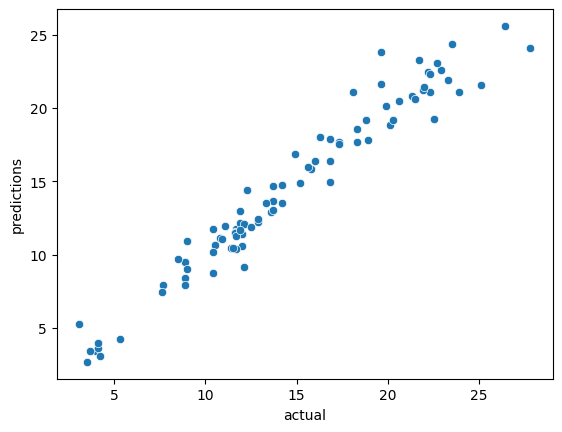

In [78]:
fig1 = sns.scatterplot(data=plotData1, x="actual", y="predictions")

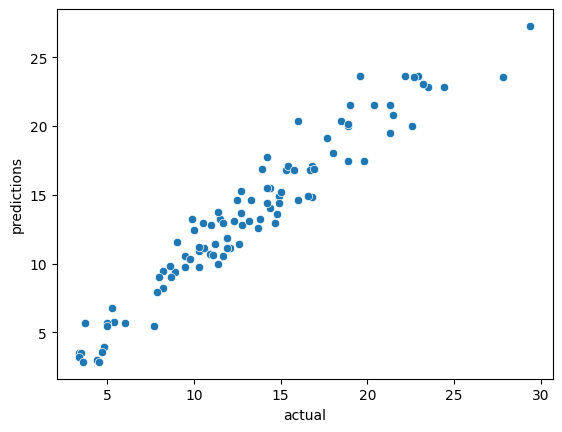

In [79]:
fig2 = sns.scatterplot(data=plotData2, x="actual", y="predictions")